# Analytical analysis #

In [1]:
import sympy
sympy.init_printing()

In [2]:
x = sympy.Symbol('x', real=True)
y = sympy.Symbol('y', real=True)
x0 = sympy.Symbol('x_0', real=True)
sx = sympy.Symbol('s_x', real=True)
intensity = sympy.Symbol('I', real=True)
phase = sympy.Symbol(r'\varphi', real=True)
a2 = sympy.Symbol('a_2', real=True)
a3 = sympy.Symbol('a_3', real=True)
offset = sympy.Symbol('y_0', real=True)

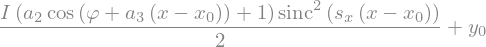

In [3]:
dx = x - x0
sdx = sx * dx
    
sinc_val = sympy.sinc(sdx)
term1 = sympy.Rational(1, 2) * sinc_val**2
term2_inner = a2 * sympy.cos(a3 * dx + phase)
term2 = 1 + term2_inner 
    
y = intensity * term1 * term2 + offset
y

## Compute Derivatives ##

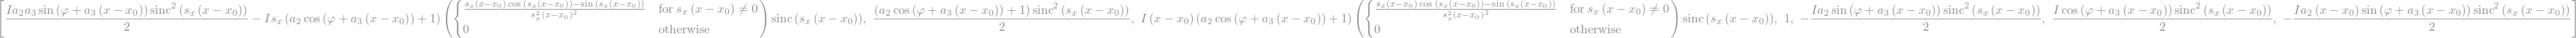

In [4]:
dy_dx0 = sympy.diff(y, x0)
dy_dI = sympy.diff(y, intensity)
dy_dxs = sympy.diff(y, sx)
dy_dy0 = sympy.diff(y, offset)
dy_dphase = sympy.diff(y, phase)
dy_da2 = sympy.diff(y, a2)
dy_da3 = sympy.diff(y, a3)

derivs = [
    dy_dx0,
    dy_dI,
    dy_dxs,
    dy_dy0,
    dy_dphase,
    dy_da2,
    dy_da3,
]
derivs

### Simplify expressions ###

In [6]:
dx_r = sympy.Symbol('dx', real=True)
dxs_r = sympy.Symbol('sdx', real=True) #hier stand dxs statt sdx 
cr = sympy.Symbol('cr', real=True)
cr2 = sympy.Symbol('cr_2', real=True)
scr = sympy.Symbol('scr', real=True)
ccr = sympy.Symbol('ccr', real=True)

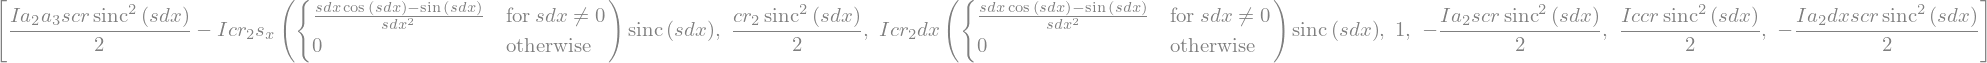

In [7]:
derivs=[
    term.subs(x, dx_r + x0)
    .subs(dx_r * sx, dxs_r)
    .subs(phase + a3 * dx_r, cr) 
    .subs(a2 * sympy.cos(cr) + 1, cr2)
    .subs(sympy.sin(cr), scr)
    .subs(sympy.cos(cr), ccr)
    for term in derivs
]
derivs

## Approximation ##

In [20]:
import numpy as np

Approximation of

$$ \frac{\cos(x)}{x}-\frac{\sin(x)}{x^2}=\mathrm{sinc}(x)\bigg[\cot(x)-\frac1x \bigg]$$

In [12]:
orig_formula=sympy.cos(x)/x - sympy.sin(x)/x**2
cot_formula =1/x * sympy.sin(x) * (sympy.cot(x) - 1/x)
tay_formula =-x/3+x**3/30-x**5/840+x**7/45360

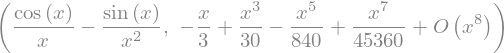

In [15]:
orig_formula,orig_formula.series(n = 8)

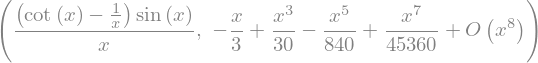

In [16]:
cot_formula,cot_formula.series(n = 8)

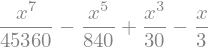

In [17]:
tay_formula

In the calcultions we will use for $x$-values close to 0 the tay_formula, since this is the one where we don't divide by 0.

We will now analyze which formula is the numerical most stable for values not in the area of 0.
We got 3 possibilities:

**A)** $$ \frac{\cos(x)}{x}-\frac{\sin(x)}{x^2}$$
**B)** $$ \frac{x\cos(x)-\sin(x)}{x^2}$$
**C)** $$ \frac{\left(\cot(x)-\frac1x\right)\sin(x)}{x}$$

In [25]:
from scipy.special import cotdg

def formula_A(z):
    return np.cos(z)/z-np.sin(z)/(z**2)
def formula_B(z):
    return (z*np.cos(z)-np.sin(z))/(z**2)
def formula_Ca(z):
    return ((1/np.tan(z)-1/z)*np.sin(z))/z
def formula_Cb(z):
    return ((cotdg((180/np.pi)*z)-1/z)*np.sin(z))/z

In [45]:
z = np.linspace(0.05, 10, num=10*60)
val_exact = [orig_formula.evalf(30,subs={x:z_i}) for z_i in z] #30 digits of precision
val_A     = formula_A(z)
val_B     = formula_B(z)
val_Ca     = formula_Ca(z)
val_Cb     = formula_Cb(z)
print("                                 Average                            Worst")
print("Performance A:   ", np.mean(np.abs(val_exact-val_A)),"   ",np.max(np.abs(val_exact-val_A)))
print("Performance B:   ", np.mean(np.abs(val_exact-val_B)),"   ",np.max(np.abs(val_exact-val_B)))
print("Performance Ca:  ", np.mean(np.abs(val_exact-val_Ca)),"   ",np.max(np.abs(val_exact-val_Ca)))
print("Performance Cb:  ", np.mean(np.abs(val_exact-val_Cb)),"   ",np.max(np.abs(val_exact-val_Cb)))

                                 Average                            Worst
Performance A:    4.12760942110344162110876073914e-17     3.02401517597190053396494705820e-15
Performance B:    2.92943450305270954720489384816e-17     1.02908317859857237539123390460e-15
Performance Ca:   3.01633842440239806311098471954e-17     6.37937439789723981133446518037e-16
Performance Cb:   4.78749091651124715130809982155e-16     4.64815201559486816885117127222e-14


We observe that formula_Ca performs best. The problem with formula_Ca is that we are diving inside by
$\tan(z)$ and $\tan(n\cdot\pi)=0$ for all $n\in\mathbb{Z}$. But although:

In [33]:
np.tan(np.pi)

formula_Ca performs good for $z=n\cdot\pi$

In [52]:
n=1
print("formula_Ca output:   ",formula_Ca(n*np.pi))
print("true output:         ",orig_formula.evalf(30,subs={x: n*sympy.pi}))
print("Error:               ",abs(formula_Ca(n*np.pi)-orig_formula.evalf(30,subs={x: n*sympy.pi})))

formula_Ca output:    -0.3183098861837907
true output:          -0.318309886183790671537767526745
Error:                1.96786766751824673929677247966e-17
